Loading dataset from merged_districts_NFHS.csv...
Dataset shape: (761, 171)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27980\2700499139.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.86100386 0.85070785 0.84298584 0.85070785 0.88674389 0.84427284
 0.86872587 0.86357786 0.83912484 0.82110682 0.78249678 0.83912484
 0.8970399  0.84555985 0.86100386 0.83912484 0.89060489 0.96010296
 0.93564994 0.94851995 0.997426   0.92921493 0.98841699 0.99485199
 0.91634492 0.97168597 0.92535393 0.98198198 0.38996139 0.42342342
 0.96653797 0.94337194 0.998713   0.96138996 0.96267696 0.94208494
 0.88030888 0.90604891 0.9021879  0.9034749  0.9047619  0.90733591
 0.90862291 0.90990991 0.90862291 0.90733591 0.89317889 0.90604891
 0.89060489 0.9047619  0.8996139  0.87644788 0.88803089 0.86615187
 0.91119691 0.90733591 0.9047619  0.88545689 0.91248391 0.8996139
 0.87902188 0.90604891 0.90862291 0.91119691 0.91248391 0.90862291
 0.8957529  0.8996139  0.91119691 0.92792793 0.92792793 0.94079794
 0.8983269  

Auto-excluding columns related to target keywords: ['Women  age 15 years and above with high (141-160 mg/dl) Blood sugar level23 (%)', 'Women age 15 years and above wih high or very high (>140 mg/dl) Blood sugar level or taking medicine to control blood sugar level23 (%)', 'Men age 15 years and above wih high (141-160 mg/dl) Blood sugar level23 (%)', 'Men (age 15 years and above wih  very high (>160 mg/dl) Blood sugar level23 (%)', 'Men age 15 years and above wih high or very high (>140 mg/dl) Blood sugar level  or taking medicine to control blood sugar level23 (%)']

Performing feature selection...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected 82 features out of 164

Training LinearRegression...
Skipping hyperparameter tuning for LinearRegression.

Training DecisionTreeRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for DecisionTreeRegressor: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}

Training RandomForestRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for RandomForestRegressor: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}

Training GradientBoostingRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for GradientBoostingRegressor: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}

Training AdaBoostRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for AdaBoostRegressor: {'n_estimators': 200, 'learning_rate': 0.2}

Training ExtraTreesRegressor...
Fitting 3 folds for eac

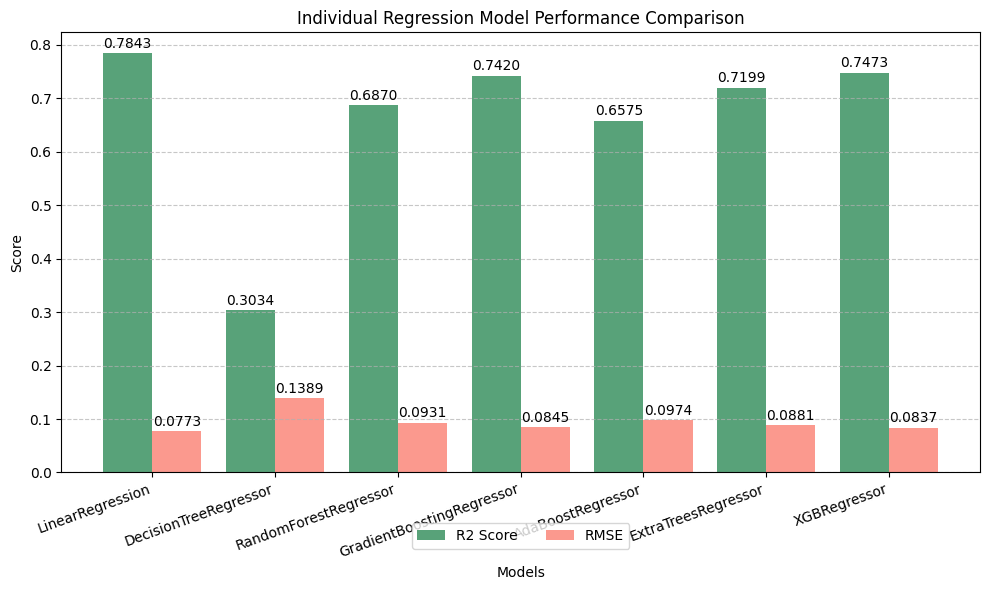

In [12]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

# Ensemble Regressors
from sklearn.ensemble import StackingRegressor, VotingRegressor

def analyze_disease_indicator(dataset_path, target_column, exclude_columns=None,
                              n_iter_search=10, cv_folds=3, save_plots=True,
                              output_dir="disease_results",
                              auto_exclude=True, auto_exclude_keywords=None):
    """
    Perform a full regression analysis for any disease (or continuous health) indicator.
    The function automatically cleans data, imputes and normalizes features,
    selects important features, tunes a variety of regression models, and evaluates them.
    It also automatically excludes features that are directly related to the target variable,
    and finally builds ensemble models (stacking and voting) using the best individual models.
    
    Parameters:
    -----------
    dataset_path : str
        Path to the CSV dataset.
    target_column : str
        Name of the continuous target variable (disease indicator) to predict.
    exclude_columns : list, optional
        Any additional columns to exclude from the feature set.
    n_iter_search : int, optional
        Number of parameter settings sampled in RandomizedSearchCV.
    cv_folds : int, optional
        Number of folds for cross-validation.
    save_plots : bool, optional
        Whether to save generated plots.
    output_dir : str, optional
        Directory in which to save output files.
    auto_exclude : bool, optional
        If True, automatically exclude features whose names contain keywords related to the target.
    auto_exclude_keywords : list, optional
        List of keywords for auto-exclusion. If not provided and auto_exclude is True,
        the function will use rules (e.g., if "sugar" is in the target, drop columns containing "sugar").
    
    Returns:
    --------
    dict
        A dictionary containing:
          - 'best_models': dictionary of best individual models and ensemble models.
          - 'best_params': hyperparameters of best individual models.
          - 'performance': list of [Model, R2 Score, RMSE] for individual models.
          - 'ensemble_performance': performance metrics for ensemble models.
          - 'selected_features': list of features selected from the original set.
    """
    # Create output directory if it doesn't exist
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 1. Data Loading and Cleaning
    print(f"Loading dataset from {dataset_path}...")
    df = pd.read_csv(dataset_path)
    print(f"Dataset shape: {df.shape}")
    
    # Replace non-numeric characters with empty string
    df.replace(r'[*()\-,]', '', regex=True, inplace=True)
    
    # Convert columns (except known non-numeric ones) to numeric
    non_numeric = ['District Names', 'State/UT']
    cols_to_numeric = [col for col in df.columns if col not in non_numeric]
    for col in cols_to_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Impute missing numeric values with KNN
    imputer = KNNImputer(n_neighbors=5)
    df.iloc[:, 2:] = imputer.fit_transform(df.iloc[:, 2:])
    
    # Normalize numeric columns using MinMaxScaler (columns from index 2 on)
    scaler = MinMaxScaler()
    df.iloc[:, 2:] = scaler.fit_transform(df.iloc[:, 2:])
    
    # 2. Rename target variable to a simplified name
    simplified_name = ''.join(c if c.isalnum() else '_' for c in target_column)
    df.rename(columns={target_column: simplified_name}, inplace=True)
    df = df.drop(columns=[col for col in df.columns if target_column in col and col != simplified_name], errors='ignore')
    
    # 3. Prepare Features and Target
    default_exclude = ['District Names', 'State/UT', simplified_name]
    if exclude_columns is None:
        exclude_columns = []
    
    # Auto-exclude features based on keywords if enabled
    auto_exclude_cols = []
    if auto_exclude:
        if auto_exclude_keywords is None:
            lower_target = target_column.lower()
            auto_exclude_keywords = []
            if "sugar" in lower_target:
                auto_exclude_keywords.append("sugar")
            # Add more keyword rules as needed
        for col in df.columns:
            col_lower = col.lower()
            if any(kw in col_lower for kw in auto_exclude_keywords) and col != simplified_name:
                auto_exclude_cols.append(col)
    
    print(f"Auto-excluding columns related to target keywords: {auto_exclude_cols}")
    all_exclude = default_exclude + exclude_columns + auto_exclude_cols
    
    X_temp = df.drop(columns=all_exclude, errors='ignore')
    # Additional safeguard: explicitly drop the target if present in features
    if simplified_name in X_temp.columns:
        X_temp = X_temp.drop(columns=[simplified_name])
    
    X = X_temp
    y = df[simplified_name]
    
    # 4. Split Data into Train, Validation, and Test sets (60-20-20)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # 5. Feature Selection using RandomForestRegressor importance
    print("\nPerforming feature selection...")
    fs_model = RandomForestRegressor(n_estimators=100, random_state=42)
    fs_model.fit(X_train, y_train)
    importances = fs_model.feature_importances_
    threshold = np.percentile(importances, 50)
    selector = SelectFromModel(fs_model, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    selected_features = X.columns[selector.get_support()]
    print(f"Selected {len(selected_features)} features out of {X.shape[1]}")
    
    # 6. Hyperparameter Tuning for Multiple Regression Models using RandomizedSearchCV
    models = {
        'LinearRegression': LinearRegression(),
        'DecisionTreeRegressor': DecisionTreeRegressor(),
        'RandomForestRegressor': RandomForestRegressor(random_state=42),
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
        'AdaBoostRegressor': AdaBoostRegressor(random_state=42),
        'ExtraTreesRegressor': ExtraTreesRegressor(random_state=42),
        'XGBRegressor': XGBRegressor(random_state=42)
    }
    
    param_grids = {
        'DecisionTreeRegressor': {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'RandomForestRegressor': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'GradientBoostingRegressor': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.6, 0.8, 1.0]
        },
        'AdaBoostRegressor': {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.2]
        },
        'ExtraTreesRegressor': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'XGBRegressor': {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
    
    best_models = {}
    best_params = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        if name == 'LinearRegression':
            model.fit(X_train_selected, y_train)
            best_models[name] = model
            print(f"Skipping hyperparameter tuning for {name}.")
        else:
            grid = param_grids.get(name, None)
            if grid is not None:
                search = RandomizedSearchCV(model, grid, n_iter=n_iter_search, cv=cv_folds,
                                            scoring='r2', verbose=1, n_jobs=-1, random_state=42)
                search.fit(X_train_selected, y_train)
                best_models[name] = search.best_estimator_
                best_params[name] = search.best_params_
                print(f"Best parameters for {name}: {search.best_params_}")
            else:
                model.fit(X_train_selected, y_train)
                best_models[name] = model
    
    # 7. Evaluate Individual Models on Test Set
    performance_results = []
    print("\nFinal Model Performance on Test Set:")
    print(f"{'Model':<25}{'R2 Score':<15}{'RMSE':<15}")
    print("=" * 55)
    for name, model in best_models.items():
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        performance_results.append([name, r2, rmse])
        print(f"{name:<25}{r2:<15.4f}{rmse:<15.4f}")
    
    # 8. Create Ensemble Models (Stacking and Voting Regressor) using the best individual models
    print("\nCreating Ensemble Models (StackingRegressor and VotingRegressor)...")
    perf_df = pd.DataFrame(performance_results, columns=['Model', 'R2 Score', 'RMSE'])
    # Sort by R2 Score and select the top 2 models
    top_models = perf_df.sort_values(by='R2 Score', ascending=False).head(2)['Model'].tolist()
    base_estimators = [(name, best_models[name]) for name in top_models]
    
    stacking_reg = StackingRegressor(
        estimators=base_estimators,
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=-1
    )
    
    voting_reg = VotingRegressor(
        estimators=base_estimators,
        n_jobs=-1
    )
    
    stacking_reg.fit(X_train_selected, y_train)
    voting_reg.fit(X_train_selected, y_train)
    
    y_pred_stack = stacking_reg.predict(X_test_selected)
    y_pred_vote = voting_reg.predict(X_test_selected)
    
    r2_stack = r2_score(y_test, y_pred_stack)
    rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
    r2_vote  = r2_score(y_test, y_pred_vote)
    rmse_vote = np.sqrt(mean_squared_error(y_test, y_pred_vote))
    
    print(f"Stacking Regressor Ensemble: R2 Score = {r2_stack:.4f}, RMSE = {rmse_stack:.4f}")
    print(f"Voting Regressor Ensemble: R2 Score = {r2_vote:.4f}, RMSE = {rmse_vote:.4f}")
    
    ensemble_performance = {
        'StackingRegressor': {'R2 Score': r2_stack, 'RMSE': rmse_stack},
        'VotingRegressor': {'R2 Score': r2_vote, 'RMSE': rmse_vote}
    }
    
    # 9. Plot Performance Comparison for Individual Models
    model_names = [res[0] for res in performance_results]
    r2_scores_list = [res[1] for res in performance_results]
    rmse_scores_list = [res[2] for res in performance_results]
    
    x = np.arange(len(model_names))
    bar_width = 0.4
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - bar_width/2, r2_scores_list, bar_width, label='R2 Score', color='seagreen', alpha=0.8)
    ax.bar(x + bar_width/2, rmse_scores_list, bar_width, label='RMSE', color='salmon', alpha=0.8)
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Individual Regression Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=20, ha='right')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i in range(len(model_names)):
        ax.text(x[i] - bar_width/2, r2_scores_list[i] + 0.005, f'{r2_scores_list[i]:.4f}', ha='center', va='bottom', fontsize=10)
        ax.text(x[i] + bar_width/2, rmse_scores_list[i] + 0.005, f'{rmse_scores_list[i]:.4f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    if save_plots:
        # plot_path = os.path.join(output_dir, f"{simplified_name}_regression_performance.png")
        plt.savefig('regression_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    # 11. Return Summary Results
    return {
        'target_column': target_column,
        'best_models': best_models,
        'best_params': best_params,
        'performance': performance_results,
        'ensemble_performance': ensemble_performance,
        'selected_features': selected_features.tolist()
    }

# Example usage:
if __name__ == "__main__":
    results = analyze_disease_indicator(
        dataset_path="merged_districts_NFHS.csv",
        target_column="Women age 15 years and above wih very high (>160 mg/dl) Blood sugar level23 (%)",
        # labels=['Low', 'Moderate', 'High'],
        exclude_columns=[],  # specify extra columns if needed
        n_iter_search=10,
        cv_folds=3,
        save_plots=True,
        output_dir="disease_results",
        auto_exclude_keywords=['sugar']
    )


In [8]:
# In a separate cell, print the selected features from the results dictionary
print("Selected Features:")
print(results['selected_features'])


Selected Features:
['Number of Households surveyed', 'Number of Women age 15-49 years interviewed', 'Number of Men age 15-54 years interviewed', 'Female population age 6 years and above who ever attended school (%)', 'Population below age 15 years (%)', ' Sex ratio of the total population (females per 1,000 males)', 'Deaths in the last 3 years registered with the civil authority (%)', 'Population living in households that use an improved sanitation facility2 (%)', 'Households using clean fuel for cooking3 (%)', 'Households using iodized salt (%)', 'Households with any usual member covered under a health insurance/financing scheme (%)', 'Children age 5 years who attended pre-primary school during the school year 2019-20 (%)', 'Women (age 15-49) who are literate4 (%)', 'Women (age 15-49)  with 10 or more years of schooling (%)', 'Women age 20-24 years married before age 18 years (%)', 'Births in the 5 years preceding the survey that are third or higher order (%)', 'Women age 15-19 years 

Loading dataset from merged_districts_NFHS.csv...
Dataset shape: (761, 171)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27980\2700499139.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.86100386 0.85070785 0.84298584 0.85070785 0.88674389 0.84427284
 0.86872587 0.86357786 0.83912484 0.82110682 0.78249678 0.83912484
 0.8970399  0.84555985 0.86100386 0.83912484 0.89060489 0.96010296
 0.93564994 0.94851995 0.997426   0.92921493 0.98841699 0.99485199
 0.91634492 0.97168597 0.92535393 0.98198198 0.38996139 0.42342342
 0.96653797 0.94337194 0.998713   0.96138996 0.96267696 0.94208494
 0.88030888 0.90604891 0.9021879  0.9034749  0.9047619  0.90733591
 0.90862291 0.90990991 0.90862291 0.90733591 0.89317889 0.90604891
 0.89060489 0.9047619  0.8996139  0.87644788 0.88803089 0.86615187
 0.91119691 0.90733591 0.9047619  0.88545689 0.91248391 0.8996139
 0.87902188 0.90604891 0.90862291 0.91119691 0.91248391 0.90862291
 0.8957529  0.8996139  0.91119691 0.92792793 0.92792793 0.94079794
 0.8983269  

Auto-excluding columns related to target keywords: []

Performing feature selection...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected 83 features out of 166

Training LinearRegression...
Skipping hyperparameter tuning for LinearRegression.

Training DecisionTreeRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for DecisionTreeRegressor: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}

Training RandomForestRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for RandomForestRegressor: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}

Training GradientBoostingRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for GradientBoostingRegressor: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}

Training AdaBoostRegressor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for AdaBoostRegressor: {'n_estimators': 200, 'learning_rate': 0.2}

Training ExtraTreesRegressor...
Fitting 3 folds for eac

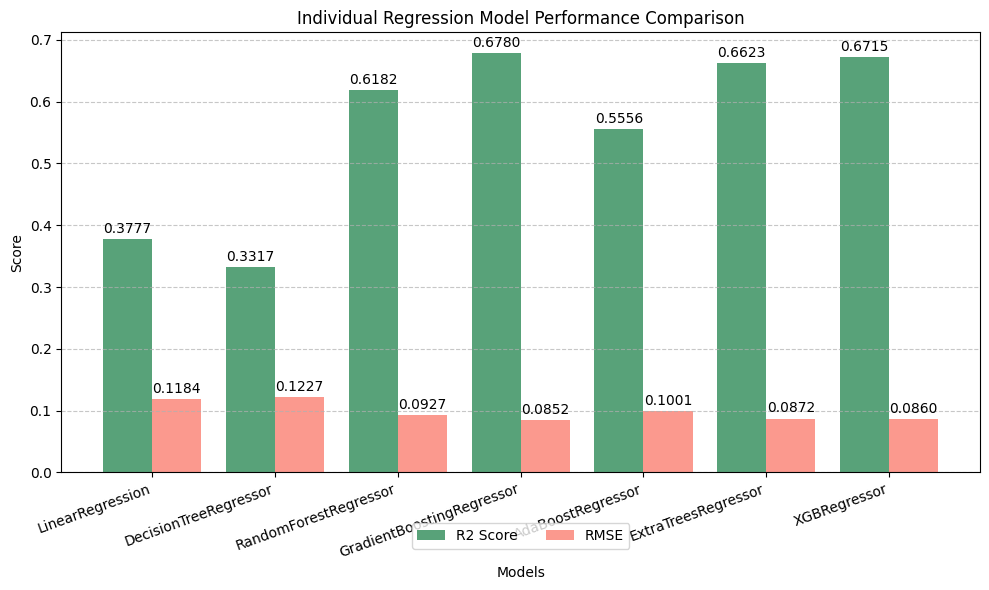

In [32]:
if __name__ == "__main__":
    results = analyze_disease_indicator(
        dataset_path="merged_districts_NFHS.csv",
        target_column="All women age 15-49 years who are anaemic22 (%)",
        exclude_columns=[ 'Pregnant women age 15-49 years who are anaemic (<11.0 g/dl)22 (%)','Non-pregnant women age 15-49 years who are anaemic (<12.0 g/dl)22 (%)', 'All women age 15-19 years who are anaemic22 (%) '],
        auto_exclude_keywords = [],
        n_iter_search=10,
        cv_folds=3,
        save_plots=True,
        output_dir="hypertension_results"
    )


In [30]:
# In a separate cell, print the selected features from the results dictionary
print("Selected Features:")
print(results['selected_features'])

Selected Features:
['Number of Households surveyed', 'Female population age 6 years and above who ever attended school (%)', 'Population below age 15 years (%)', 'Sex ratio at birth for children born in the last five years (females per 1,000 males)', 'Population living in households with electricity (%)', 'Population living in households with an improved drinking-water source1 (%)', 'Population living in households that use an improved sanitation facility2 (%)', 'Households using clean fuel for cooking3 (%)', 'Households using iodized salt (%)', 'Households with any usual member covered under a health insurance/financing scheme (%)', 'Children age 5 years who attended pre-primary school during the school year 2019-20 (%)', 'Women (age 15-49) who are literate4 (%)', 'Women (age 15-49)  with 10 or more years of schooling (%)', 'Women age 20-24 years married before age 18 years (%)', 'Births in the 5 years preceding the survey that are third or higher order (%)', 'Women age 15-19 years wh